### Set GPU

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [7]:
dataset_name = 'CIFAR10'
# dataset_name = 'CIFAR100'
# dataset_name = 'MNIST'
# dataset_name = 'TINYIMAGENET'
# dataset_name = "IMBALANCED_CIFAR10"

In [11]:
import torch
import numpy as np
from tqdm import tqdm

import glob

import os
import sys
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

add_path(os.path.abspath('/home/chominhi/work/init-pools-dal-main'))
from pycls.models.vae import VanillaVAE,VanillaVAE2
from pycls.models.vae import loss_function as VAELoss

In [13]:
model_folder = ''
output_folder = ''
if dataset_name == "CIFAR10":
    output_folder += '/home/chominhi/work/init-pools-dal-main'  #수정함
    model_folder += '/home/chominhi/work/init-pools-dal-main/output/CIFAR10/VAE/VAE_2/'
    config_path = '/home/chominhi/work/init-pools-dal-main/configs/cifar10/ssl/VAE.yaml'
elif dataset_name == "CIFAR100":
    output_folder += '/results/cifar-100/'
    model_folder += '/output/CIFAR100/VAE/VAE_1/'
    config_path = '/configs/cifar100/ssl/VAE.yaml'
elif dataset_name == "MNIST":
    output_folder += '/results/mnist/'
    model_folder += '/output/MNIST/VAE/VAE_1/'
    config_path = '/configs/mnist/ssl/VAE.yaml'
elif dataset_name == "TINYIMAGENET":
    output_folder += '/results/tinyimagenet/'
    model_folder += '/output/TINYIMAGENET/VAE/VAE_1/'
    config_path = '/configs/tinyimagenet/ssl/VAE.yaml'
if dataset_name == "IMBALANCED_CIFAR10":
    output_folder += '/results/imbalanced-cifar-10/'
    model_folder += '/output/IMBALANCED_CIFAR10/VAE/VAE_1/'
    config_path = '/configs/cifar10/ssl/VAE_IM.yaml'

In [14]:
path_to_model = glob.glob(model_folder+'*.pyth')[0]   

temp = torch.load(path_to_model)

IndexError: list index out of range

In [ ]:
model = VanillaVAE(in_channels=3, latent_dim=128)
model.load_state_dict(temp['model_state'])
model.eval()
model.cuda();

In [ ]:
model

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_m

In [ ]:
from pycls.datasets.data import Data
from pycls.core.config import cfg


cfg.merge_from_file(config_path)
cfg.DATASET.NAME = dataset_name
data_obj = Data(cfg)
data_obj.eval_mode = True
# train_data, train_size = data_obj.getDataset(save_dir=f'../data', isTrain=True, isDownload=True)
train_data, train_size = data_obj.getDataset(save_dir=cfg.DATASET.ROOT_DIR, isTrain=True, isDownload=True)

Files already downloaded and verified


In [ ]:
trainSet = [i for i in range(len(train_data))]
trainSet = np.array(trainSet, dtype=np.ndarray)
train_dataloader = data_obj.getSequentialDataLoader(indexes=trainSet, batch_size=5, data=train_data)

In [ ]:
image_losses = []
for images, _ in tqdm(train_dataloader, desc="Calculating VAE Loss: "):
    criterion = VAELoss
    with torch.no_grad():
        images = images.cuda(non_blocking=True)
        images_recon, inputs, mu, log_var = model(images)
        loss, recons_loss, kld_loss = criterion(images_recon, images, mu, log_var, 128/len(train_data))
        image_losses.append(loss.item())
        break

Calculating VAE Loss:   0%|          | 0/50000 [00:00<?, ?it/s]


In [ ]:
image_losses = np.array(image_losses)

In [ ]:
np.save(f'{output_folder}/{dataset_name}_VAE_losses.npy', image_losses)
print('파일 만들어졌음')

NameError: name 'np' is not defined

###  Visualizing VAE Reconstructions

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10,3))
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
#     plt.savefig('SimCLR_Loss_Example.png')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


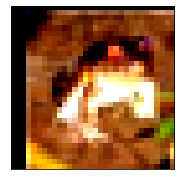

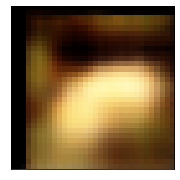

In [ ]:
imshow(torchvision.utils.make_grid(images.cpu()))
imshow(torchvision.utils.make_grid(images_recon.cpu()))